In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from msresist.clustering import DDMC
from msresist.pre_processing import filter_NaNpeptides
from msresist.pre_processing import preprocessing
import statannot
from bioinfokit import visuz
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [2]:
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [3]:
# def heatmap_ClusterVsTargets_Corr(targets, omic="Protein", title=False):
#     """Plot correlations between clusters and targets"""
#     tar = pd.DataFrame()
#     for t in targets:
#         try:
#             if omic == "Protein":
#                 tar[t] = protC[t]
#             elif omic == "RNA":
#                 tar[t] = rnaC[t]
#         except BaseException:
#             print(t + " not present in the data set")
#             continue
#     tar = tar.astype(float)
#     tar.index += 1
#     g = sns.clustermap(tar.astype(float), figsize=(10, 9), cmap="bwr")
#     if title:
#         g.fig.suptitle(title)

In [4]:
rnaC = pd.read_csv("msresist/data/MS/CPTAC/Omics_results/mRNA_Cluster_Correlations.csv").drop("Unnamed: 0", axis=1)
protC = pd.read_csv("msresist/data/MS/CPTAC/Omics_results/prot_Cluster_Correlations.csv").drop("Unnamed: 0", axis=1)

# Change column labels to Symbol genes
rnaC.columns = rnaC.iloc[-1, :]
rnaC = rnaC.iloc[:-1, :]
protC.columns = protC.iloc[-1, :]
protC = protC.iloc[:-1, :]

In [5]:
def preprocess_data(X):
    xR = X.set_index("geneSymbol").select_dtypes(include=float)
    xR_tumor = xR.loc[:, ~xR.columns.str.endswith(".N")]
    xR_tumor = xR_tumor.reindex(sorted(xR_tumor.columns), axis=1)
    xR_nat = xR.loc[:, xR.columns.str.endswith(".N")]
    xR_nat = xR_nat.reindex(sorted(xR_nat.columns), axis=1)

    l1 = list(xR_tumor.columns)
    l2 = [s.split(".N")[0] for s in list(xR_nat.columns)]
    dif = [i for i in l1 + l2 if i not in l1 or i not in l2]
    xR_tumor = xR_tumor.drop(dif, axis=1)
    assert all(xR_tumor.columns.values == np.array(l2)), "Samples don't match"

    l1 = list(xR_tumor.index)
    xR_nat = xR_nat.drop(['SORBS2', 'PKP1', 'IGSF10', 'PANX1', 'PLCXD3', 'MYLK2'], axis=0)
    l2 = list(xR_nat.index)
    dif = [i for i in l1 + l2 if i not in l1 or i not in l2]
    xR_tumor = xR_tumor.drop(dif, axis=0)
    assert all(xR_tumor.index == np.array(l2)), "Samples don't match"

    return xR, xR_tumor, xR_nat


def preprocess_phospho(X):
    xR = X.set_index("Gene").select_dtypes(include=float)
    xR_tumor = xR.loc[:, ~xR.columns.str.endswith(".N")]
    xR_tumor = xR_tumor.reindex(sorted(xR_tumor.columns), axis=1)
    xR_nat = xR.loc[:, xR.columns.str.endswith(".N")]
    xR_nat = xR_nat.reindex(sorted(xR_nat.columns), axis=1)

    l1 = list(xR_tumor.columns)
    l2 = [s.split(".N")[0] for s in list(xR_nat.columns)]
    dif = [i for i in l1 + l2 if i not in l1 or i not in l2]
    xR_tumor = xR_tumor.drop(dif, axis=1)
    assert all(xR_tumor.columns.values == np.array(l2)), "Samples don't match"

    l1 = list(xR_tumor.index)
    l2 = list(xR_nat.index)
    dif = [i for i in l1 + l2 if i not in l1 or i not in l2]
    xR_tumor = xR_tumor.drop(dif, axis=0)
    assert all(xR_tumor.index == np.array(l2)), "Samples don't match"

    xR.insert(0, "Position", X["Position"].values)
    xR.insert(0, "Sequence", X["Sequence"].values)
    xR = xR.reset_index().set_index(["Gene", "Position", "Sequence"])
    xR_tumor.insert(0, "Position", X["Position"].values)
    xR_tumor.insert(0, "Sequence", X["Sequence"].values)
    xR_tumor = xR_tumor.reset_index().set_index(["Gene", "Position", "Sequence"])
    xR_nat.insert(0, "Position", X["Position"].values)
    xR_nat.insert(0, "Sequence", X["Sequence"].values)
    xR_nat = xR_nat.reset_index().set_index(["Gene", "Position", "Sequence"])

    return xR, xR_tumor, xR_nat

In [6]:
X = filter_NaNpeptides(pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:], tmt=2)
prot = pd.read_csv("msresist/data/MS/CPTAC/CPTAC_LUAD_Protein.csv").drop_duplicates(subset="geneSymbol").set_index("geneSymbol").select_dtypes(include=float).iloc[:, 4:].reset_index()
rna = pd.read_csv("msresist/data/MS/CPTAC/CPTAC_LUAD_RNAseq.csv").drop_duplicates(subset="geneSymbol")

/Users/creixell/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
phoR, phoR_tumor, phoR_nat = preprocess_phospho(X)
protR, protR_tumor, protR_nat = preprocess_data(prot)
rnaR, rnaR_tumor, rnaR_nat = preprocess_data(rna)

In [8]:
def TumorVsNAT_target(target, xR_nat, xR_tumor):
    out = pd.DataFrame()
    out["Patient_ID"] = list(xR_nat.columns) + list(xR_tumor.columns)
    out["Type"] = ["NAT"] * xR_nat.shape[1] + ["Tumor"] * xR_tumor.shape[1]
    out["Expression"] = list(np.squeeze(xR_nat.loc[target].values)) + list(np.squeeze(xR_tumor.loc[target].values))
    return out

In [9]:
# axlP = TumorVsNAT_target("AXL", protR_nat, protR_tumor)
# axlR = TumorVsNAT_target("AXL", rnaR_nat, rnaR_tumor)

# _, ax = plt.subplots(1, 2, figsize=(10, 5))
# sns.histplot(data=axlP, x="Expression", hue="Type", kde=True, ax=ax[0]).set_title("total AXL")
# sns.histplot(data=axlR, x="Expression", hue="Type", kde=True, ax=ax[1]).set_title("mRNA AXL")
# plt.savefig("AXL_TvN.svg")

In [10]:
# yapP = TumorVsNAT_target("YAP1", protR_nat, protR_tumor)
# yapR = TumorVsNAT_target("YAP1", rnaR_nat, rnaR_tumor)

# _, ax = plt.subplots(1, 2, figsize=(10, 5))
# sns.histplot(data=yapP, x="Expression", hue="Type", kde=True, ax=ax[0]).set_title("total YAP")
# sns.histplot(data=yapR, x="Expression", hue="Type", kde=True, ax=ax[1]).set_title("mRNA YAP")
# plt.savefig("YAP_TvN.svg")

In [11]:
# phoR_noS = phoR.reset_index().drop("Sequence", axis=1).set_index(["Gene", "Position"])

In [12]:
# import warnings
# warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# def plot_psite_distribution(rows, cols, phoR, protein, figsize=(15, 12)):
#     tot_plots = rows * cols
#     fig = plt.figure(1, figsize=figsize)
#     pos = range(1, tot_plots + 1)
#     for ii, p_site in enumerate(phoR.loc[protein].index):
#         p_yap = TumorVsNAT_target((protein, p_site), phoR_nat, phoR_tumor)
#         ax = fig.add_subplot(rows, cols, pos[ii])
#         sns.histplot(data=p_yap, x="Expression", hue="Type", kde=True, ax=ax).set_title("p-" + protein + " " + p_site)

#     fig.tight_layout()

# plot_psite_distribution(4, 5, phoR_noS, "YAP1")

In [13]:
# ablP = TumorVsNAT_target("ABL2", protR_nat, protR_tumor)
# ablR = TumorVsNAT_target("ABL1", rnaR_nat, rnaR_tumor)

# _, ax = plt.subplots(1, 2, figsize=(10, 5))
# sns.histplot(data=ablP, x="Expression", hue="Type", kde=True, ax=ax[0]).set_title("total ABL2")
# sns.histplot(data=ablR, x="Expression", hue="Type", kde=True, ax=ax[1]).set_title("mRNA ABL1")

In [14]:
# plot_psite_distribution(2, 5, phoR_noS, "ABL1", figsize=(15, 6))

In [15]:
# plot_psite_distribution(2, 2, phoR_noS, "SRC", figsize=(6, 5))

## AXL correlation

In [11]:
def pair_corr(X, p1, p2, ax, title=""):
    corr = pd.DataFrame()
    corr[p1] = X.loc[p1].values
    corr[p2] = X.loc[p2].values
    sns.regplot(data=corr, x=p1, y=p2, ax=ax).set_title(title)

In [12]:
prot = protR_tumor
rna = rnaR_tumor
phos = phoR_tumor

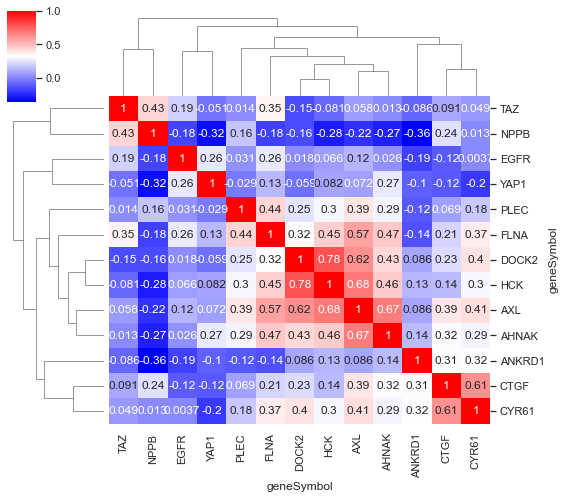

In [64]:
targ = ["AXL", "EGFR", "YAP1", "TAZ", "CTGF", "CYR61", "NPPB", "ANKRD1", "PLEC", "AHNAK", "DOCK2", "FLNA", "HCK"]
sns.clustermap(rna.loc[targ].T.corr(method="pearson").fillna(0), cmap="bwr", figsize=(8, 7), annot=True)
# plt.savefig("AXLcorr_rna.svg")

In [61]:
phos.shape

(30561, 102)

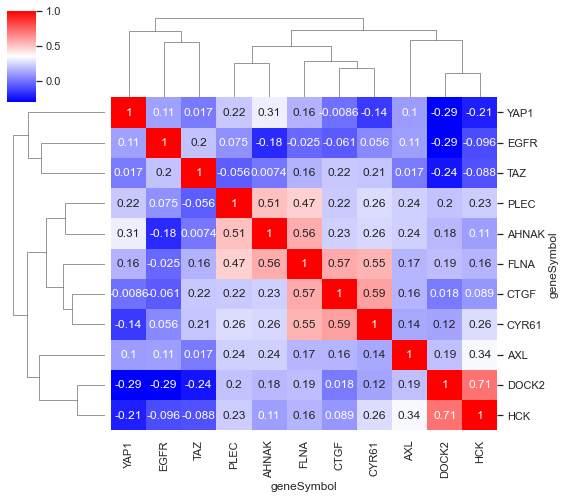

In [14]:
targ = ["AXL", "EGFR", "YAP1", "TAZ", "CTGF", "CYR61", "PLEC", "AHNAK", "DOCK2", "FLNA", "HCK"]
sns.clustermap(prot.loc[targ].T.corr().fillna(0), cmap="bwr", figsize=(8, 7), annot=True)
# plt.savefig("AXLcorr_prot.svg")

In [20]:
# fig, ax = plt.subplots(1, 4, figsize=(16, 4))
# fig.tight_layout()
# pair_corr(prot, "AXL", "YAP1", ax=ax[0], title="Protein")
# pair_corr(rna, "AXL", "YAP1", ax=ax[1], title="RNA")
# pair_corr(rna, "YAP1", "CTGF", ax=ax[2], title="RNA")
# pair_corr(rna, "AXL", "CTGF", ax=ax[3], title="RNA")

In [21]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# fig.tight_layout()
# pair_corr(rna, "AXL", "CYR61", ax=ax[0])
# pair_corr(rna, "AXL", "CTGF", ax=ax[1])
# fig.savefig("AXL_YAPtarg_corr.svg")

In [22]:
# _, ax = plt.subplots(1, 4, figsize=(20, 4))
# pair_corr(rna, "AXL", "DOCK2", ax=ax[0], title="PLEC")
# pair_corr(rna, "AXL", "PLEC", ax=ax[1], title="AHNAK")
# pair_corr(rna, "AXL", "AHNAK", ax=ax[2], title="DOCK2")
# pair_corr(rna, "AXL", "FLNA", ax=ax[3], title="FLNA")
# plt.savefig("AXLint.svg")

In [23]:
# fig, ax = plt.subplots(1, 1, figsize=(5, 4))
# pair_corr(rna, "AXL", "ABL2", ax=ax)
# plt.savefig("HCK_AXLcorr.svg")

In [24]:
# fig, ax = plt.subplots(1, 6, figsize=(25, 4))
# fig.tight_layout()
# pair_corr(rna, "AXL", "HCK", ax=ax[0])
# pair_corr(rna, "AXL", "SRC", ax=ax[1])
# pair_corr(rna, "AXL", "LYN", ax=ax[2])
# pair_corr(rna, "AXL", "FYN", ax=ax[3])
# pair_corr(rna, "AXL", "BLK", ax=ax[4])
# pair_corr(rna, "AXL", "CSNK2A1", ax=ax[5])

In [24]:
# fig, ax = plt.subplots(1, 6, figsize=(25, 4))
# fig.tight_layout()
# pair_corr(rna, "AXL", "PTPN11", ax=ax[0])
# pair_corr(rna, "AXL", "ABL1", ax=ax[1])
# pair_corr(rna, "AXL", "PRKCD", ax=ax[2])
# pair_corr(rna, "AXL", "TNK2", ax=ax[3])
# pair_corr(rna, "AXL", "MAPK1", ax=ax[4])
# pair_corr(rna, "AXL", "MAPK3", ax=ax[5])

In [25]:
# _, ax = plt.subplots(1, 3, figsize=(12, 4))
# pair_corr(rna, "EGFR", "PLEC", ax=ax[0], title="PLEC")
# pair_corr(rna, "EGFR", "AHNAK", ax=ax[1], title="AHNAK")
# pair_corr(rna, "EGFR", "DOCK2", ax=ax[2], title="DOCK2")

## Stratifying tumors by AXL levels

### Differential protein expression in AXLhi vs AXLlow tumors

In [88]:
def find_axl_levels(prot, up_thres=0.25, low_thresh=-0.5):
    """ Find AXLhi & AXLlow """
    prot_axl = pd.DataFrame(prot.loc["AXL"])
    axl = prot.loc["AXL"].values
    axl_levels = np.where(axl <= low_thresh, "Low", axl)
    axl_levels = np.where(axl >= up_thres, "High", axl_levels)
    axl_levels = np.where((axl >= low_thresh) & (axl <= up_thres), "Med", axl_levels)
    prot_axl["Levels"] = axl_levels
    return prot_axl


def volcano(X, prot, gene_label, export=False, multiple_testing=True, lfc_thr=(1, 1), pv_thr=(0.05, 0.05)):
    l1 = list(prot.loc["AXL"].index)
    l2 = list(X.columns)
    dif = [i for i in l1 + l2 if i not in l1 or i not in l2]
    X = X.drop(dif, axis=1)
    assert all(X.columns.values == np.array(l1)), "Samples don't match"

    # Find AXLhi & AXLlow
    prot_axl = find_axl_levels(prot)
    axl_hi = X[list(prot_axl[prot_axl["Levels"] == "High"].index)]
    axl_low = X[list(prot_axl[prot_axl["Levels"] == "Low"].index)]

    # Statistical Testing
    pvals = mannwhitneyu(axl_hi, axl_low, axis=1, nan_policy="omit")[1]
    if multiple_testing:
        pvals = multipletests(pvals)[1]

    # Plot
    prot_fc = pd.DataFrame()
    prot_fc["Protein"] = axl_hi.reset_index()[gene_label].values
    prot_fc["Position"] = axl_hi.reset_index()["Position"].values
    prot_fc["logFC"] = axl_hi.mean(axis=1).values - axl_low.mean(axis=1).values
    prot_fc["p-values"] = pvals
    prot_fc = prot_fc.sort_values(by="p-values")
    visuz.GeneExpression.volcano(df=prot_fc.dropna(), lfc='logFC', pv='p-values', lfc_thr=lfc_thr, pv_thr=pv_thr, show=True, geneid="Protein", genenames='deg', figtype="svg", dim=(10, 8))

    if export:
        return prot_fc

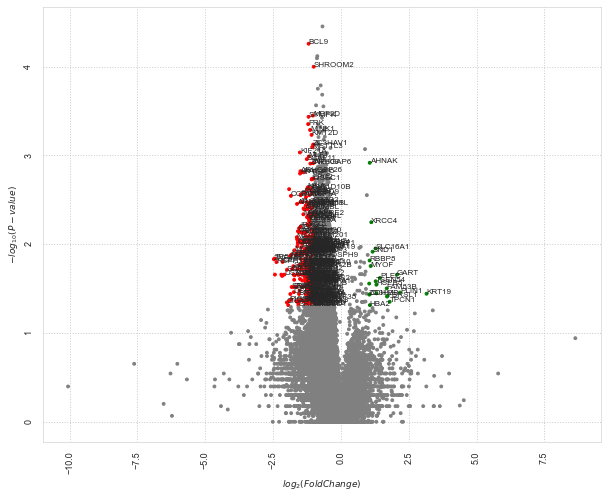

In [89]:
enr = volcano(phos, prot, gene_label="Gene", multiple_testing=False, export=True)

In [95]:
enr[enr["Protein"] == "FLNA"].dropna().iloc[:100]

,Protein,Position,logFC,p-values
26906,FLNA,S2180-p,-0.387249,0.017429
24736,FLNA,Y1525-p,-0.787665,0.030987
17243,FLNA,T2209-p,-0.636727,0.073604
24711,FLNA,T2175-p,-0.334732,0.074982
20356,FLNA,S368-p,-0.371537,0.081964
1692,FLNA,S2356-p,-0.479412,0.096894
24793,FLNA,S977-p,-0.406599,0.102332
16157,FLNA,T2179-p,-0.349964,0.115859
24701,FLNA,Y1938-p,-0.615249,0.117840
25749,FLNA,S11-p,-0.369636,0.122586


In [21]:
def make_AXL_categorical_data(X, prot, phospho=False):
    prot_axl = find_axl_levels(prot)
    hi_and_low = prot_axl[(prot_axl["Levels"] == "High") | (prot_axl["Levels"] == "Low")]
    axlHL = X[list(hi_and_low.index)]
    axlHL.columns = hi_and_low["Levels"].values
    axlHL = axlHL.reset_index()
    if phospho:
        axlHL = pd.melt(frame=axlHL, id_vars=["Gene", "Position", "Sequence"], value_vars=axlHL.columns[2:], var_name="AXL", value_name="p-site signal").set_index(["Gene", "Position"])
    else:
        axlHL = pd.melt(frame=axlHL, id_vars=["geneSymbol"], value_vars=axlHL.columns[2:], var_name="AXL", value_name="log(expression)").set_index(["geneSymbol"])
    return axlHL


In [22]:
def annotate_pvals(ax, df, x, y, hue=None):
    statannot.add_stat_annotation(
        ax=ax, 
        data=df, 
        x=x, 
        y=y, 
        hue=hue, 
        box_pairs=[("High", "Low")], 
        test="t-test_ind", 
        text_format="star", 
        loc="outside",
        verbose=False)

/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/429851269.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/429851269.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/429851269.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/429851269.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/429851269.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/42985

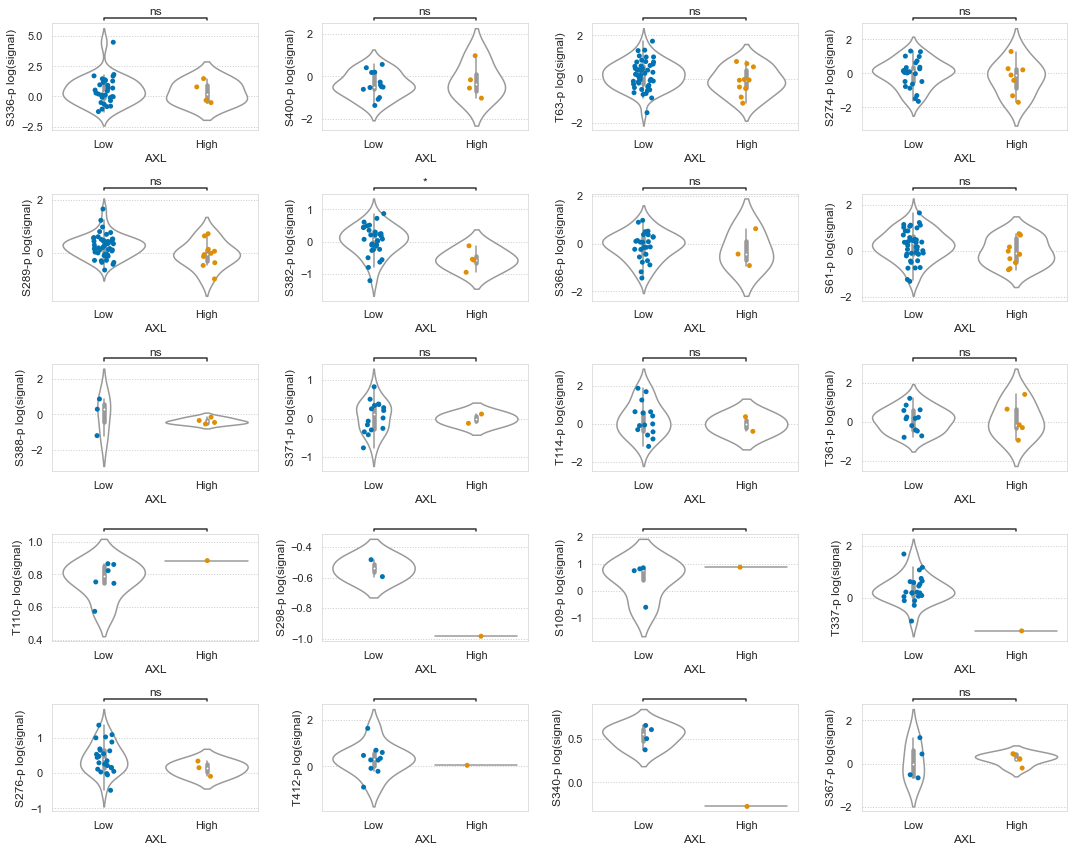

In [61]:
def plot_psites_byAXLlevels(rows, cols, data, protein, figsize=(15, 12)):
    tot_plots = rows * cols
    fig = plt.figure(1, figsize=figsize)
    pos = range(1, tot_plots + 1)
    for ii, p_site in enumerate(list(set(data.loc[protein].index))):
        dd = data.loc[protein, p_site]
        ax = fig.add_subplot(rows, cols, pos[ii])
        sns.violinplot(data=dd, x="AXL", y="p-site signal", color="white", ax=ax)
        sns.stripplot(data=dd, x="AXL", y="p-site signal", ax=ax).set_ylabel(p_site + " log(signal)")
        annotate_pvals(ax, dd, "AXL", "p-site signal", hue=None)

    fig.tight_layout()

phosHL = make_AXL_categorical_data(phos, prot, phospho=True)
plot_psites_byAXLlevels(5, 4, phosHL, "YAP1", figsize=(15, 12))
plt.savefig("YAP_HvL.svg")

In [65]:
rna_axl = find_axl_levels(prot)
targ = ["AXL", "YAP1", "TAZ", "CTGF", "CYR61", "PLEC", "AHNAK", "DOCK2", "FLNA", "HCK", "SRC", "ABL1", "FYN", "LYN", "FRK", "YES1", "BCAR1", "PTPN11", "TNK2", "MAPK1", "MAPK3"]
rna_pca = rna.loc[targ].T.reset_index()
rna_pca["Levels"] = rna_axl["Levels"].values
rna_pca

geneSymbol,index,AXL,YAP1,TAZ,CTGF,CYR61,PLEC,AHNAK,DOCK2,FLNA,...,FYN,LYN,FRK,YES1,BCAR1,PTPN11,TNK2,MAPK1,MAPK3,Levels
0,C3L.00001,-0.6367,0.4169,-0.1780,0.0080,1.0347,-0.4358,-1.0401,-0.3683,0.0619,...,-0.4567,-0.2586,0.6086,-0.0927,-0.0648,0.4061,0.2368,0.0800,-0.0652,Low
1,C3L.00009,0.1803,-0.4112,-0.3750,-0.2943,-0.0069,0.0822,-0.0473,-0.1464,-0.4638,...,-1.1464,0.2803,0.1233,-0.2490,-0.0287,0.1137,-0.4862,0.1867,-0.8714,Med
2,C3L.00080,-1.3645,-0.4564,-1.1032,-2.0805,-1.6462,-0.3679,-2.3503,-0.9528,-1.6049,...,-0.7355,-0.1947,0.7426,0.5825,-1.1929,1.2402,0.4886,-0.5754,-0.4021,Low
3,C3L.00083,0.4465,-0.7374,0.8096,-0.0369,1.2475,1.8395,-0.0366,0.5695,0.7073,...,0.3818,0.1711,-0.1474,-0.9668,0.9384,-0.1797,2.0891,-1.1707,-0.2215,Low
4,C3L.00093,-0.0177,-0.3439,-0.2425,-0.1767,-0.0644,-0.1141,-0.2943,0.0322,-0.1471,...,-0.6537,0.6343,0.9674,0.4346,-0.3433,-0.2129,-0.3642,-0.1940,-0.3362,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,C3N.02582,-0.5839,0.8398,0.5239,-1.6346,-1.0834,0.9084,-0.7161,-0.8509,0.1025,...,-1.0769,-0.4141,1.7342,0.6506,0.1705,-0.0155,0.3057,-0.7864,0.0379,Low
97,C3N.02586,-0.3038,0.3418,0.8312,-1.3393,-1.3083,0.3531,-1.3948,-0.9258,-0.2547,...,-0.8338,0.5375,1.1509,-0.0647,0.3317,-0.0984,0.7067,0.0000,-0.8331,High
98,C3N.02587,-0.3044,0.5361,0.3209,-1.6385,-1.5587,-0.0912,-0.9343,-0.3006,0.3636,...,-2.0527,0.1043,-0.3103,0.0970,0.0399,-0.0185,-0.2330,-0.3759,-0.1569,Med
99,C3N.02588,-0.9416,-0.0773,-0.4043,-0.9490,-1.5340,-0.1678,-2.8015,-0.9026,-0.6392,...,-1.1888,0.5806,1.7827,1.1929,0.1699,-0.1992,0.8811,-0.1501,-0.3978,Med


No handles with labels found to put in legend.
No handles with labels found to put in legend.


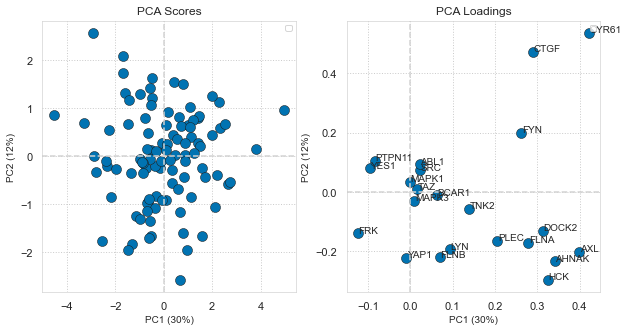

In [95]:
targ = ["AXL", "YAP1", "TAZ", "CTGF", "CYR61", "PLEC", "AHNAK", "DOCK2", "FLNA", "HCK", "SRC", "ABL1", "FYN", "LYN", "FRK", "YES1", "FLNB", "BCAR1", "PTPN11", "TNK2", "MAPK1", "MAPK3"]
rna_pca = rna.loc[targ].T.reset_index()
rna_pca["Levels"] = rna_axl["Levels"].values
rna_pca = rna_pca.dropna(axis=1)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotPCA(ax, rna_pca, 4, ["index"])

/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Py

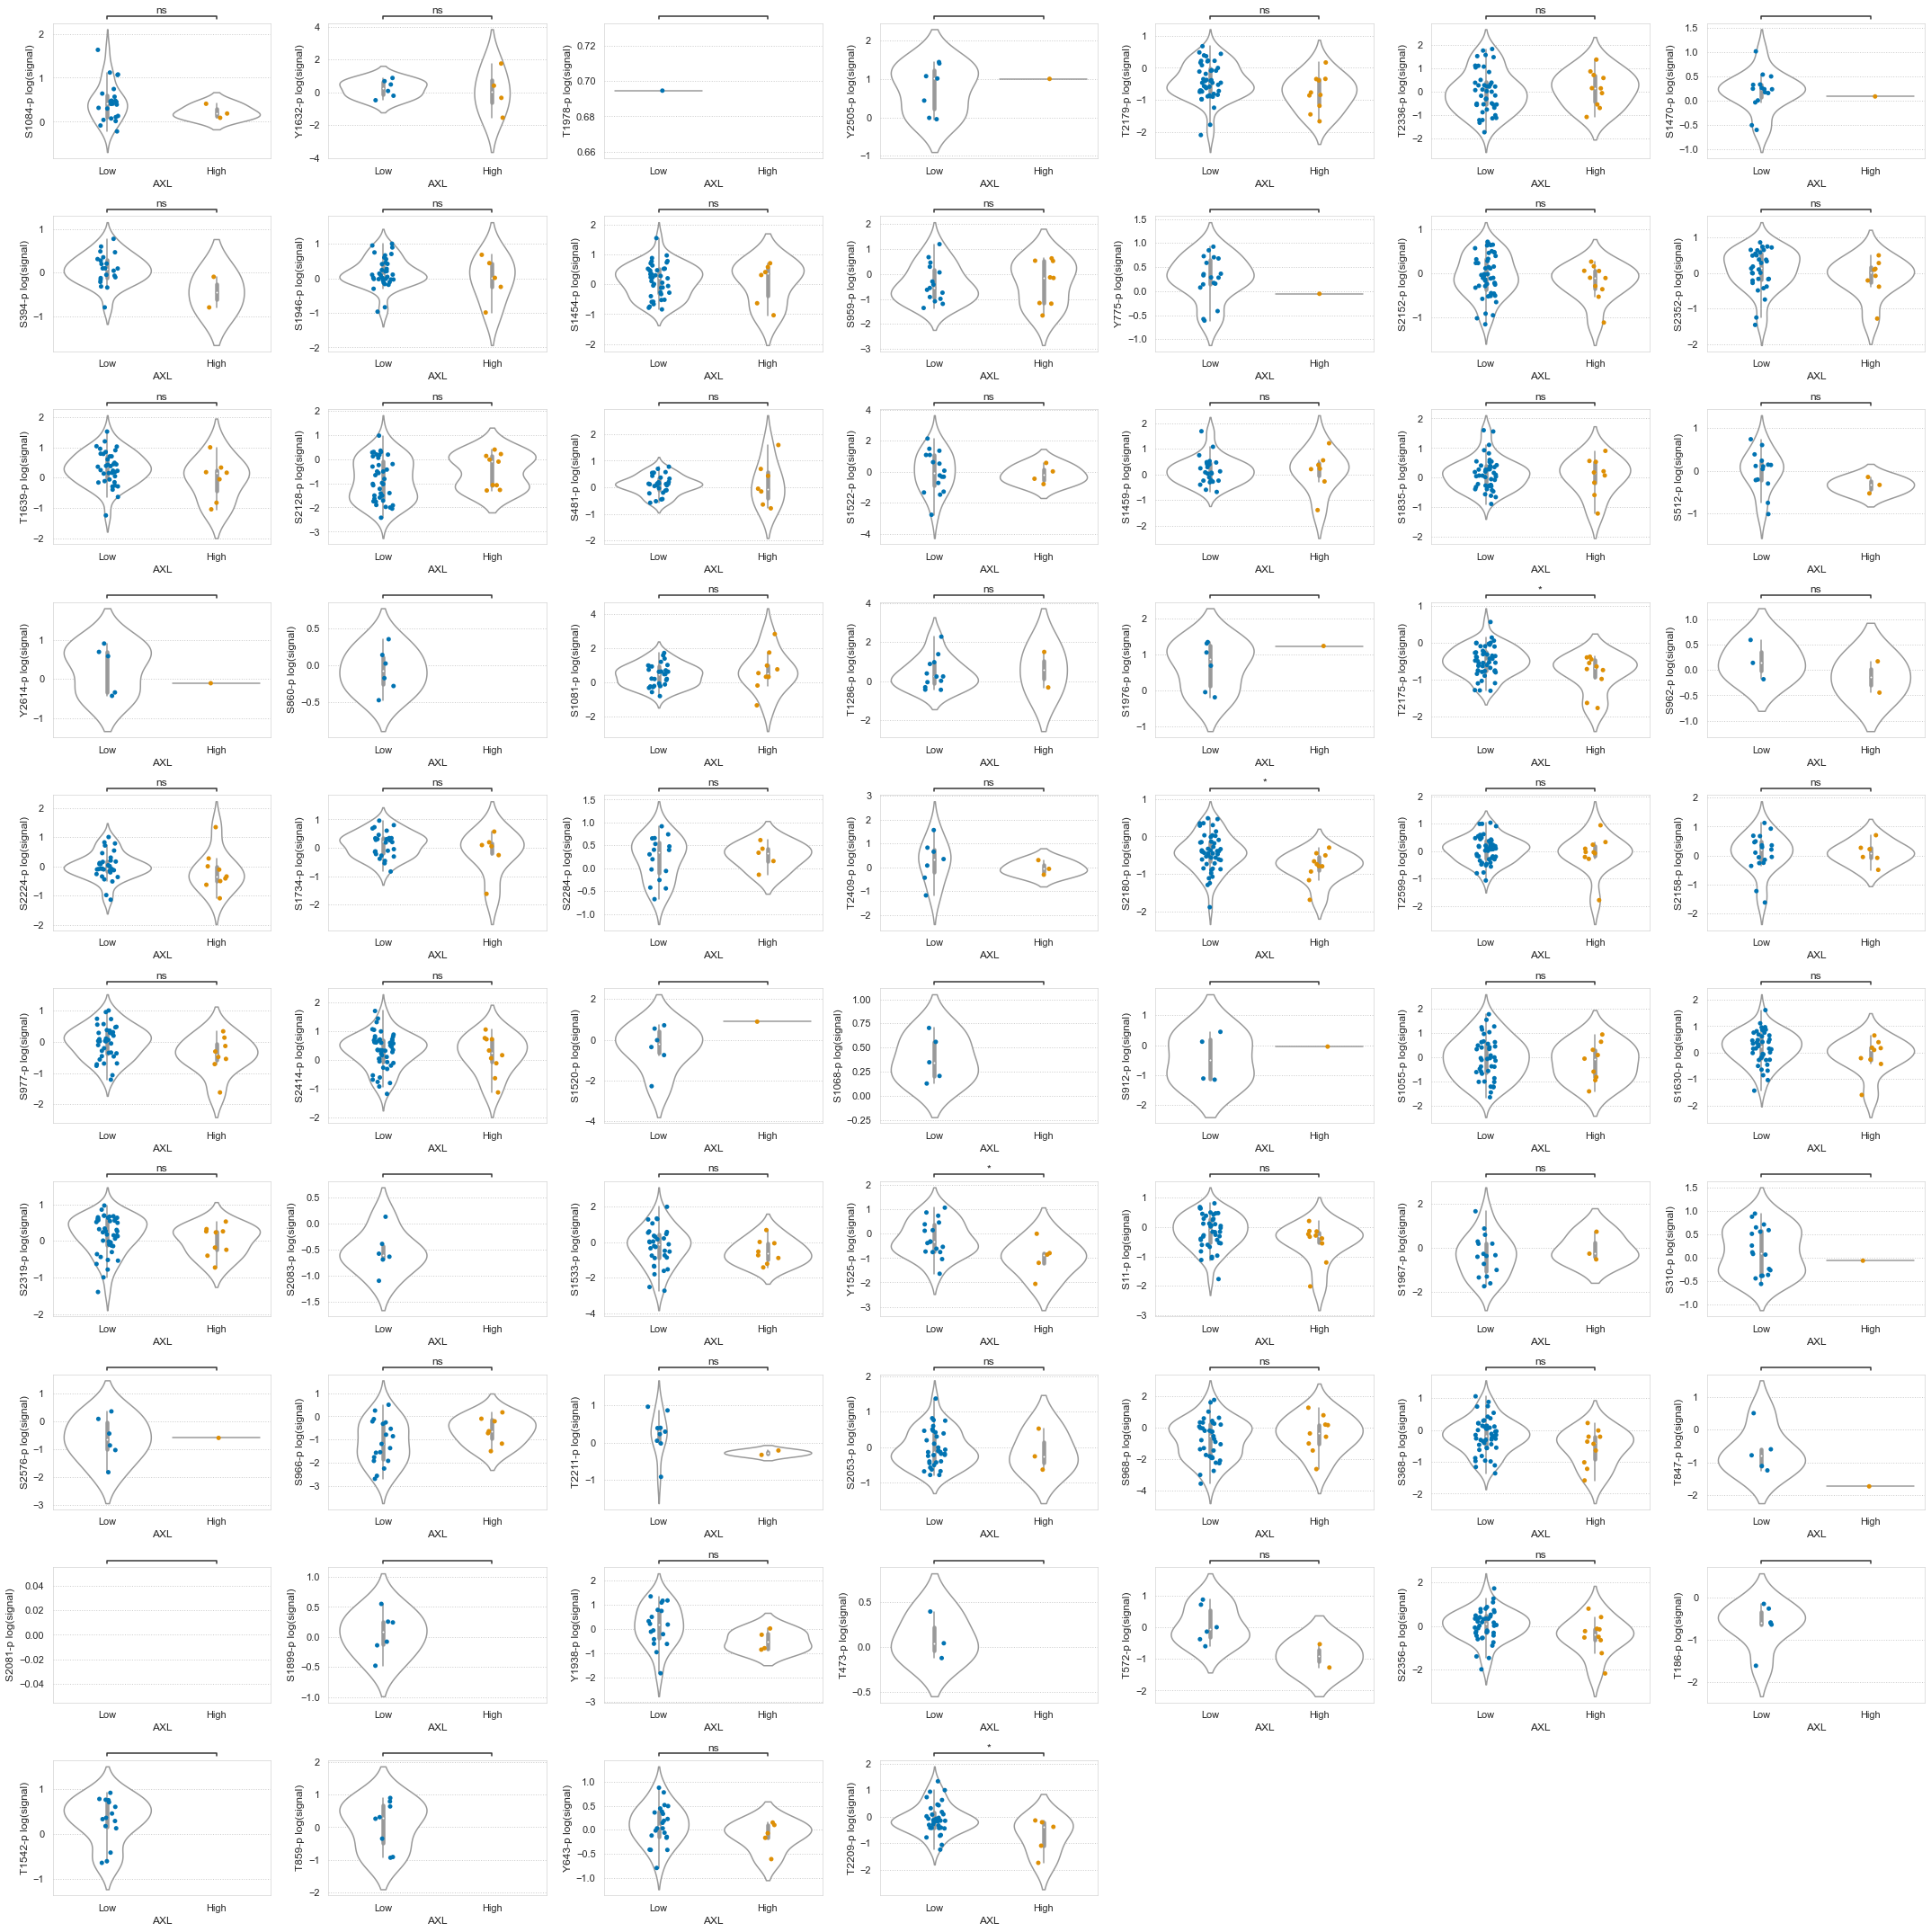

In [24]:
plot_psites_byAXLlevels(10, 7, phosHL, "FLNA", figsize=(30, 30))

/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]


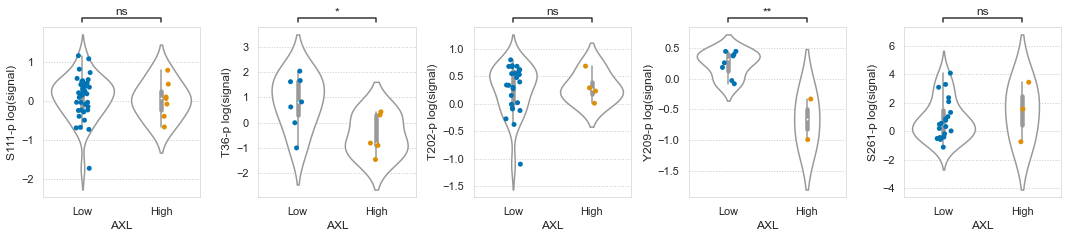

In [35]:
plot_psites_byAXLlevels(2, 5, phosHL, "HCK", figsize=(15, 6))
plt.savefig("HCK_HvL.svg")

/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/3643950823.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dd = data.loc[protein, p_site]
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/

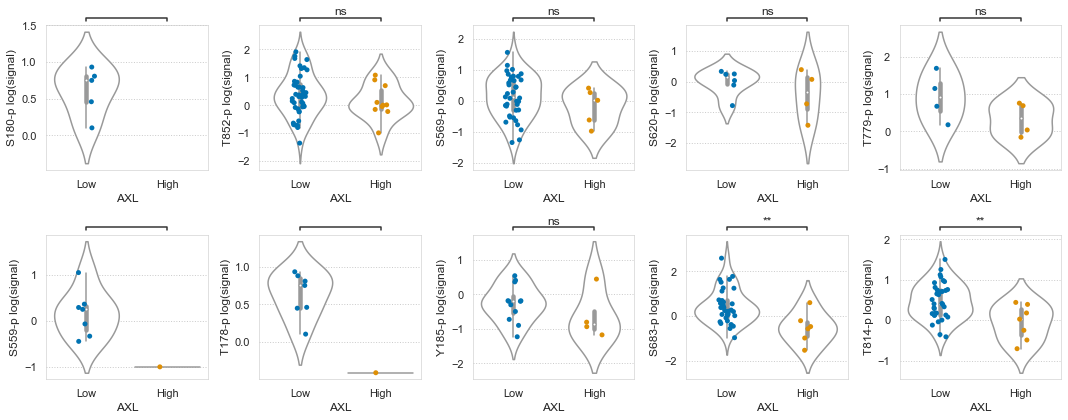

In [36]:
plot_psites_byAXLlevels(2, 5, phosHL, "ABL1", figsize=(15, 6))
plt.savefig("ABL_HvL.svg")

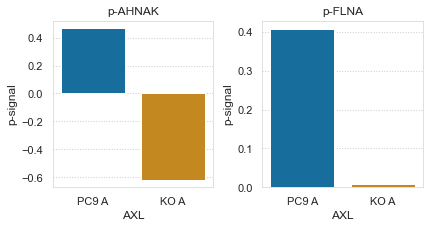

In [37]:
axl_ms = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)

def plot_WTvKO_axlms(gene, ax):
    d = axl_ms[axl_ms["Gene"] == gene][["PC9 A", "KO A"]].T.reset_index()
    d.columns = ["AXL", "p-signal"]
    sns.barplot(data=d, x="AXL", y="p-signal", ax=ax).set_title("p-" + gene)

fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharex=True)
fig.tight_layout()
plot_WTvKO_axlms("AHNAK", ax[0])
plot_WTvKO_axlms("FLNA", ax[1])
plt.savefig("AXLms_bar.svg")

/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/2371943538.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.violinplot(data=phosHL.loc["DOCK2", "S1755-p"], x="AXL", y="p-site signal", color="white", ax=ax[0])
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/2371943538.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.stripplot(data=phosHL.loc["DOCK2", "S1755-p"], x="AXL", y="p-site signal", ax=ax[0]).set_ylabel("p-DOCK2 log(signal)")
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/2371943538.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  annotate_pvals(ax[0], phosHL.loc["DOCK2", "S1755-p"], "AXL", "p-site signal", hue=None)
/var/folders/qz/7zyfxvhx06q9y2ykk30slw200000gn/T/ipykernel_90261/2371943538.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.violinplot(data=phosHL.loc["AHNAK", "S216-p"], x="AXL", 

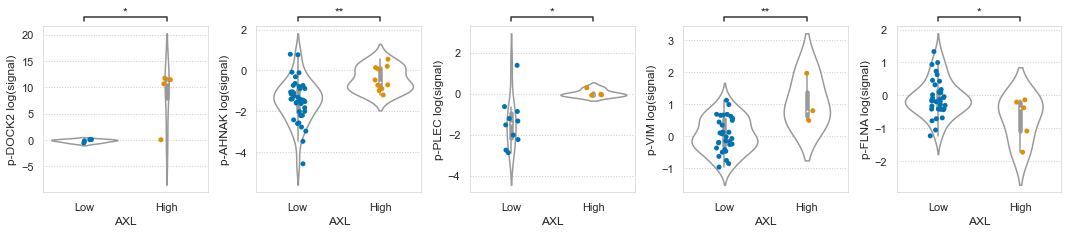

In [80]:
phosHL = make_AXL_categorical_data(phos, prot, phospho=True)

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
fig.tight_layout()
sns.violinplot(data=phosHL.loc["DOCK2", "S1755-p"], x="AXL", y="p-site signal", color="white", ax=ax[0])
sns.stripplot(data=phosHL.loc["DOCK2", "S1755-p"], x="AXL", y="p-site signal", ax=ax[0]).set_ylabel("p-DOCK2 log(signal)")
annotate_pvals(ax[0], phosHL.loc["DOCK2", "S1755-p"], "AXL", "p-site signal", hue=None)

sns.violinplot(data=phosHL.loc["AHNAK", "S216-p"], x="AXL", y="p-site signal", color="white", ax=ax[1])
sns.stripplot(data=phosHL.loc["AHNAK", "S216-p"], x="AXL", y="p-site signal", ax=ax[1]).set_ylabel("p-AHNAK log(signal)")
annotate_pvals(ax[1], phosHL.loc["AHNAK", "S216-p"], "AXL", "p-site signal", hue=None)

sns.violinplot(data=phosHL.loc["PLEC", "S1721-p"], x="AXL", y="p-site signal", color="white", ax=ax[2])
sns.stripplot(data=phosHL.loc["PLEC", "S1721-p"], x="AXL", y="p-site signal", ax=ax[2]).set_ylabel("p-PLEC log(signal)")
annotate_pvals(ax[2], phosHL.loc["PLEC", "S1721-p"], "AXL", "p-site signal", hue=None)

sns.violinplot(data=phosHL.loc["VIM", "Y117-p"], x="AXL", y="p-site signal", color="white", ax=ax[3])
sns.stripplot(data=phosHL.loc["VIM", "Y117-p"], x="AXL", y="p-site signal", ax=ax[3]).set_ylabel("p-VIM log(signal)")
annotate_pvals(ax[3], phosHL.loc["VIM", "Y117-p"], "AXL", "p-site signal", hue=None)

sns.violinplot(data=phosHL.loc["FLNA", "T2209-p"], x="AXL", y="p-site signal", color="white", ax=ax[4])
sns.stripplot(data=phosHL.loc["FLNA", "T2209-p"], x="AXL", y="p-site signal", ax=ax[4]).set_ylabel("p-FLNA log(signal)")
annotate_pvals(ax[4], phosHL.loc["FLNA", "T2209-p"], "AXL", "p-site signal", hue=None)

plt.savefig("AXLinteractors_phospho.svg")

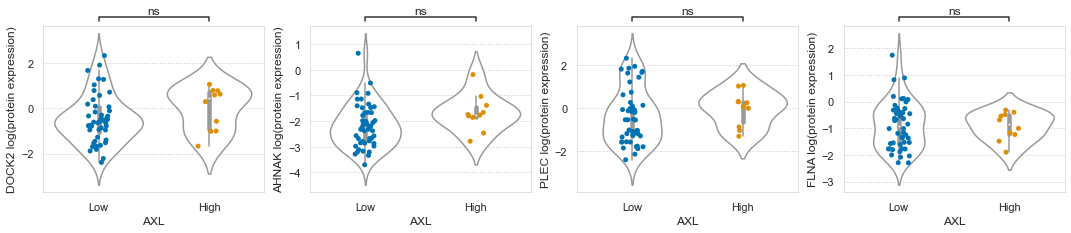

In [46]:
protHL = make_AXL_categorical_data(prot, prot, phospho=False)

fig, ax = plt.subplots(1, 4, figsize=(15, 3))
fig.tight_layout()

sns.violinplot(data=protHL.loc["DOCK2"], x="AXL", y="log(expression)", color="white", ax=ax[0])
sns.stripplot(data=protHL.loc["DOCK2"], x="AXL", y="log(expression)", ax=ax[0]).set_ylabel("DOCK2 log(protein expression)")
annotate_pvals(ax[0], protHL.loc["DOCK2"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["AHNAK"], x="AXL", y="log(expression)", color="white", ax=ax[1])
sns.stripplot(data=protHL.loc["AHNAK"], x="AXL", y="log(expression)", ax=ax[1]).set_ylabel("AHNAK log(protein expression)")
annotate_pvals(ax[1], protHL.loc["AHNAK"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["PLEC"], x="AXL", y="log(expression)", color="white", ax=ax[2])
sns.stripplot(data=protHL.loc["PLEC"], x="AXL", y="log(expression)", ax=ax[2]).set_ylabel("PLEC log(protein expression)")
annotate_pvals(ax[2], protHL.loc["PLEC"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["FLNA"], x="AXL", y="log(expression)", color="white", ax=ax[3])
sns.stripplot(data=protHL.loc["FLNA"], x="AXL", y="log(expression)", ax=ax[3]).set_ylabel("FLNA log(protein expression)")
annotate_pvals(ax[3], protHL.loc["FLNA"], "AXL", "log(expression)", hue=None)

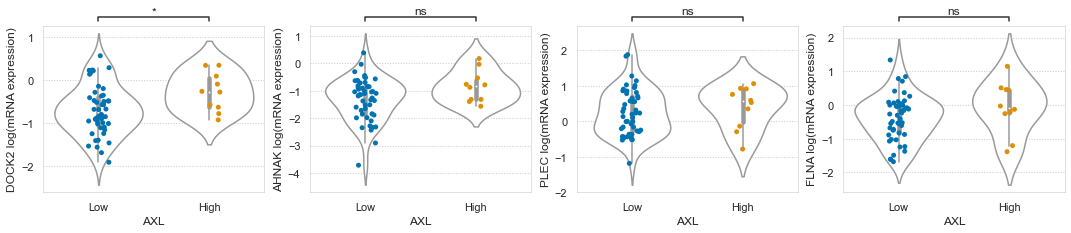

In [40]:
rnaHL = make_AXL_categorical_data(rna, prot, phospho=False)

fig, ax = plt.subplots(1, 4, figsize=(15, 3))
fig.tight_layout()
sns.violinplot(data=rnaHL.loc["DOCK2"], x="AXL", y="log(expression)", color="white", ax=ax[0])
sns.stripplot(data=rnaHL.loc["DOCK2"], x="AXL", y="log(expression)", ax=ax[0]).set_ylabel("DOCK2 log(mRNA expression)")
annotate_pvals(ax[0], rnaHL.loc["DOCK2"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["AHNAK"], x="AXL", y="log(expression)", color="white", ax=ax[1])
sns.stripplot(data=rnaHL.loc["AHNAK"], x="AXL", y="log(expression)", ax=ax[1]).set_ylabel("AHNAK log(mRNA expression)")
annotate_pvals(ax[1], rnaHL.loc["AHNAK"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["PLEC"], x="AXL", y="log(expression)", color="white", ax=ax[2])
sns.stripplot(data=rnaHL.loc["PLEC"], x="AXL", y="log(expression)", ax=ax[2]).set_ylabel("PLEC log(mRNA expression)")
annotate_pvals(ax[2], rnaHL.loc["PLEC"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["FLNA"], x="AXL", y="log(expression)", color="white", ax=ax[3])
sns.stripplot(data=rnaHL.loc["FLNA"], x="AXL", y="log(expression)", ax=ax[3]).set_ylabel("FLNA log(mRNA expression)")
annotate_pvals(ax[3], rnaHL.loc["FLNA"], "AXL", "log(expression)", hue=None)

plt.savefig("AXLint_mRNA.svg")

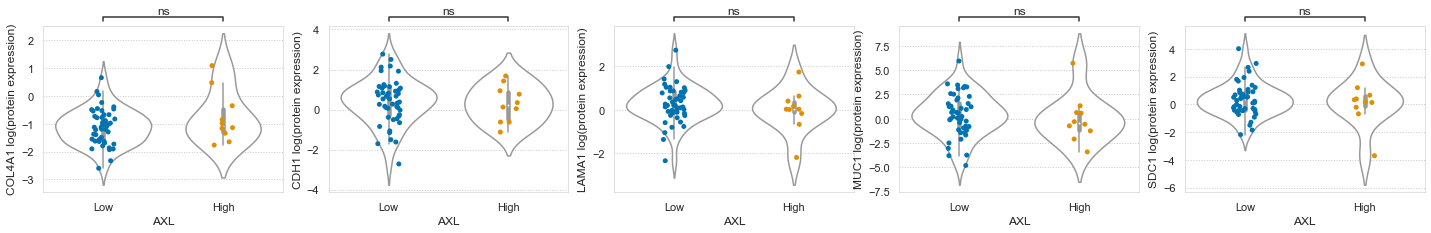

In [40]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
fig.tight_layout()

sns.violinplot(data=protHL.loc["COL4A1"], x="AXL", y="log(expression)", color="white", ax=ax[0])
sns.stripplot(data=protHL.loc["COL4A1"], x="AXL", y="log(expression)", ax=ax[0]).set_ylabel("COL4A1 log(protein expression)")
annotate_pvals(ax[0], protHL.loc["COL4A1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["CDH1"], x="AXL", y="log(expression)", color="white", ax=ax[1])
sns.stripplot(data=protHL.loc["CDH1"], x="AXL", y="log(expression)", ax=ax[1]).set_ylabel("CDH1 log(protein expression)")
annotate_pvals(ax[1], protHL.loc["CDH1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["LAMA1"], x="AXL", y="log(expression)", color="white", ax=ax[2])
sns.stripplot(data=protHL.loc["LAMA1"], x="AXL", y="log(expression)", ax=ax[2]).set_ylabel("LAMA1 log(protein expression)")
annotate_pvals(ax[2], protHL.loc["LAMA1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["MUC1"], x="AXL", y="log(expression)", color="white", ax=ax[3])
sns.stripplot(data=protHL.loc["MUC1"], x="AXL", y="log(expression)", ax=ax[3]).set_ylabel("MUC1 log(protein expression)")
annotate_pvals(ax[3], protHL.loc["MUC1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["SDC1"], x="AXL", y="log(expression)", color="white", ax=ax[4])
sns.stripplot(data=protHL.loc["SDC1"], x="AXL", y="log(expression)", ax=ax[4]).set_ylabel("SDC1 log(protein expression)")
annotate_pvals(ax[4], protHL.loc["SDC1"], "AXL", "log(expression)", hue=None)

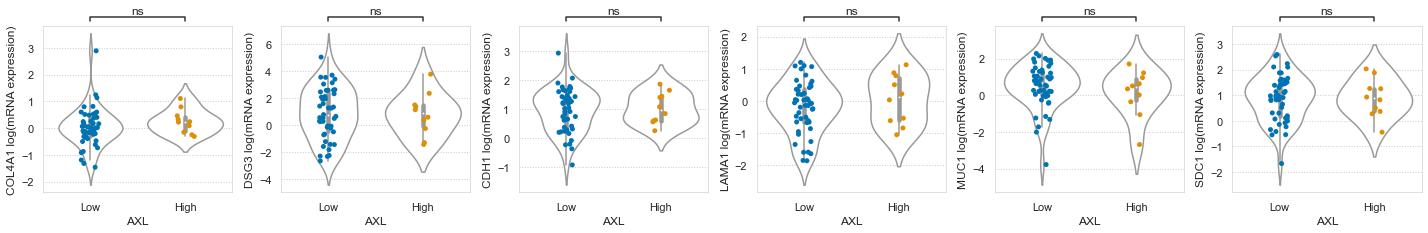

In [45]:
fig, ax = plt.subplots(1, 6, figsize=(20, 3))
fig.tight_layout()

sns.violinplot(data=rnaHL.loc["COL4A1"], x="AXL", y="log(expression)", color="white", ax=ax[0])
sns.stripplot(data=rnaHL.loc["COL4A1"], x="AXL", y="log(expression)", ax=ax[0]).set_ylabel("COL4A1 log(mRNA expression)")
annotate_pvals(ax[0], rnaHL.loc["COL4A1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["DSG3"], x="AXL", y="log(expression)", color="white", ax=ax[1])
sns.stripplot(data=rnaHL.loc["DSG3"], x="AXL", y="log(expression)", ax=ax[1]).set_ylabel("DSG3 log(mRNA expression)")
annotate_pvals(ax[1], rnaHL.loc["DSG3"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["CDH1"], x="AXL", y="log(expression)", color="white", ax=ax[2])
sns.stripplot(data=rnaHL.loc["CDH1"], x="AXL", y="log(expression)", ax=ax[2]).set_ylabel("CDH1 log(mRNA expression)")
annotate_pvals(ax[2], rnaHL.loc["CDH1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["LAMA1"], x="AXL", y="log(expression)", color="white", ax=ax[3])
sns.stripplot(data=rnaHL.loc["LAMA1"], x="AXL", y="log(expression)", ax=ax[3]).set_ylabel("LAMA1 log(mRNA expression)")
annotate_pvals(ax[3], rnaHL.loc["LAMA1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["MUC1"], x="AXL", y="log(expression)", color="white", ax=ax[4])
sns.stripplot(data=rnaHL.loc["MUC1"], x="AXL", y="log(expression)", ax=ax[4]).set_ylabel("MUC1 log(mRNA expression)")
annotate_pvals(ax[4], rnaHL.loc["MUC1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["SDC1"], x="AXL", y="log(expression)", color="white", ax=ax[5])
sns.stripplot(data=rnaHL.loc["SDC1"], x="AXL", y="log(expression)", ax=ax[5]).set_ylabel("SDC1 log(mRNA expression)")
annotate_pvals(ax[5], rnaHL.loc["SDC1"], "AXL", "log(expression)", hue=None)

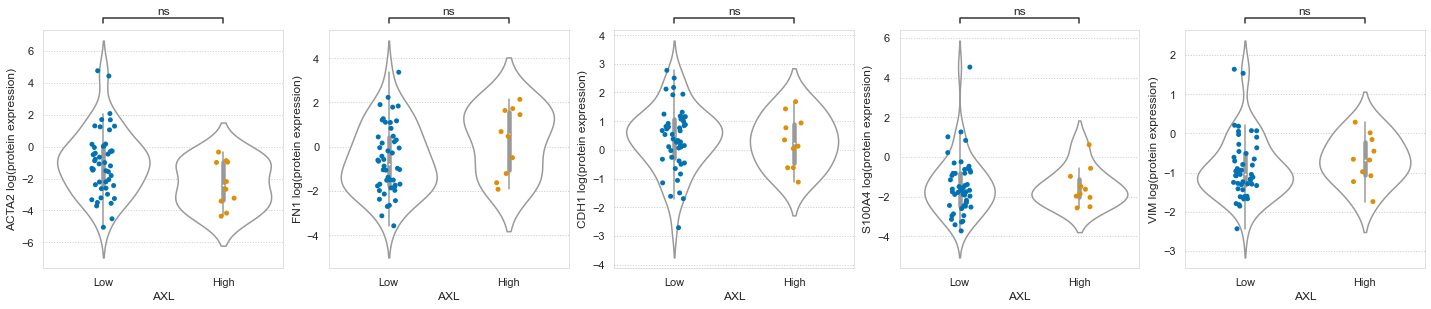

In [47]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.tight_layout()

sns.violinplot(data=protHL.loc["ACTA2"], x="AXL", y="log(expression)", color="white", ax=ax[0])
sns.stripplot(data=protHL.loc["ACTA2"], x="AXL", y="log(expression)", ax=ax[0]).set_ylabel("ACTA2 log(protein expression)")
annotate_pvals(ax[0], protHL.loc["ACTA2"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["FN1"], x="AXL", y="log(expression)", color="white", ax=ax[1])
sns.stripplot(data=protHL.loc["FN1"], x="AXL", y="log(expression)", ax=ax[1]).set_ylabel("FN1 log(protein expression)")
annotate_pvals(ax[1], protHL.loc["FN1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["CDH1"], x="AXL", y="log(expression)", color="white", ax=ax[2])
sns.stripplot(data=protHL.loc["CDH1"], x="AXL", y="log(expression)", ax=ax[2]).set_ylabel("CDH1 log(protein expression)")
annotate_pvals(ax[2], protHL.loc["CDH1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["S100A4"], x="AXL", y="log(expression)", color="white", ax=ax[3])
sns.stripplot(data=protHL.loc["S100A4"], x="AXL", y="log(expression)", ax=ax[3]).set_ylabel("S100A4 log(protein expression)")
annotate_pvals(ax[3], protHL.loc["S100A4"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["VIM"], x="AXL", y="log(expression)", color="white", ax=ax[4])
sns.stripplot(data=protHL.loc["VIM"], x="AXL", y="log(expression)", ax=ax[4]).set_ylabel("VIM log(protein expression)")
annotate_pvals(ax[4], protHL.loc["VIM"], "AXL", "log(expression)", hue=None)

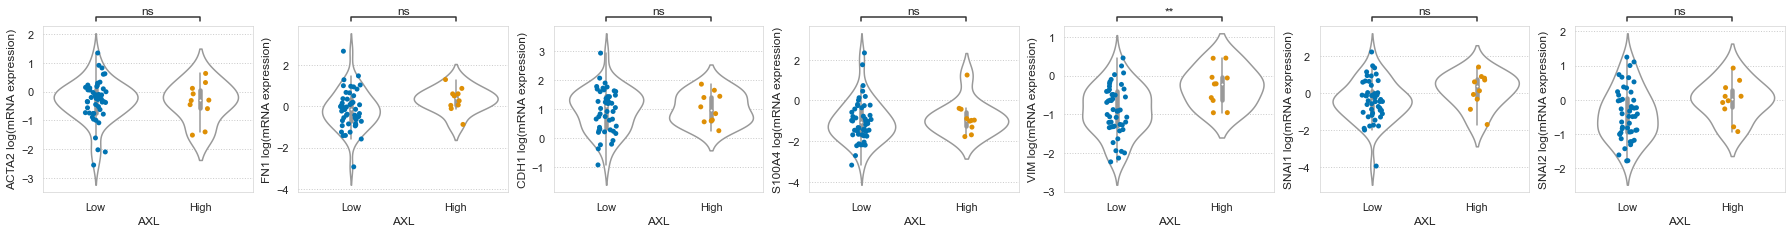

In [41]:
fig, ax = plt.subplots(1, 7, figsize=(25, 3))
fig.tight_layout()

sns.violinplot(data=rnaHL.loc["ACTA2"], x="AXL", y="log(expression)", color="white", ax=ax[0])
sns.stripplot(data=rnaHL.loc["ACTA2"], x="AXL", y="log(expression)", ax=ax[0]).set_ylabel("ACTA2 log(mRNA expression)")
annotate_pvals(ax[0], rnaHL.loc["ACTA2"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["FN1"], x="AXL", y="log(expression)", color="white", ax=ax[1])
sns.stripplot(data=rnaHL.loc["FN1"], x="AXL", y="log(expression)", ax=ax[1]).set_ylabel("FN1 log(mRNA expression)")
annotate_pvals(ax[1], rnaHL.loc["FN1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["CDH1"], x="AXL", y="log(expression)", color="white", ax=ax[2])
sns.stripplot(data=rnaHL.loc["CDH1"], x="AXL", y="log(expression)", ax=ax[2]).set_ylabel("CDH1 log(mRNA expression)")
annotate_pvals(ax[2], rnaHL.loc["CDH1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["S100A4"], x="AXL", y="log(expression)", color="white", ax=ax[3])
sns.stripplot(data=rnaHL.loc["S100A4"], x="AXL", y="log(expression)", ax=ax[3]).set_ylabel("S100A4 log(mRNA expression)")
annotate_pvals(ax[3], rnaHL.loc["S100A4"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["VIM"], x="AXL", y="log(expression)", color="white", ax=ax[4])
sns.stripplot(data=rnaHL.loc["VIM"], x="AXL", y="log(expression)", ax=ax[4]).set_ylabel("VIM log(mRNA expression)")
annotate_pvals(ax[4], rnaHL.loc["VIM"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["SNAI1"], x="AXL", y="log(expression)", color="white", ax=ax[5])
sns.stripplot(data=rnaHL.loc["SNAI1"], x="AXL", y="log(expression)", ax=ax[5]).set_ylabel("SNAI1 log(mRNA expression)")
annotate_pvals(ax[5], rnaHL.loc["SNAI1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["SNAI2"], x="AXL", y="log(expression)", color="white", ax=ax[6])
sns.stripplot(data=rnaHL.loc["SNAI2"], x="AXL", y="log(expression)", ax=ax[6]).set_ylabel("SNAI2 log(mRNA expression)")
annotate_pvals(ax[6], rnaHL.loc["SNAI2"], "AXL", "log(expression)", hue=None)

plt.savefig("MesenchMarkers.svg")

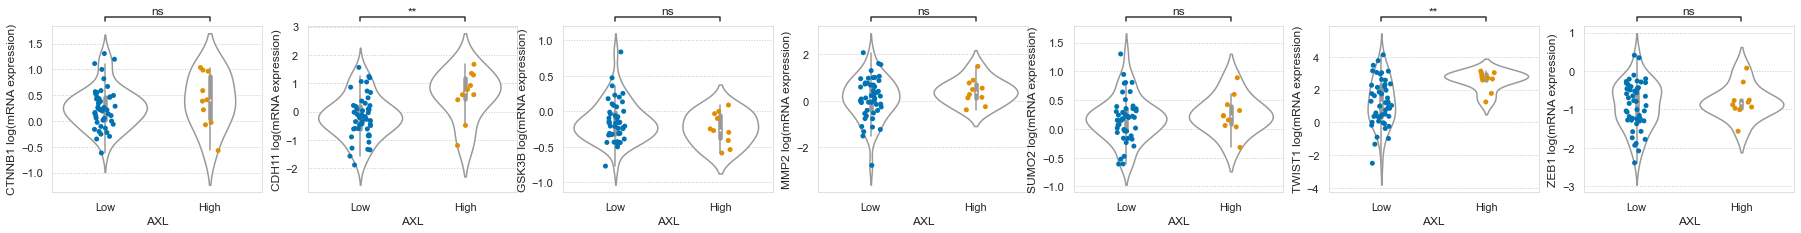

In [42]:
fig, ax = plt.subplots(1, 7, figsize=(25, 3))
fig.tight_layout()

sns.violinplot(data=rnaHL.loc["CTNNB1"], x="AXL", y="log(expression)", color="white", ax=ax[0])
sns.stripplot(data=rnaHL.loc["CTNNB1"], x="AXL", y="log(expression)", ax=ax[0]).set_ylabel("CTNNB1 log(mRNA expression)")
annotate_pvals(ax[0], rnaHL.loc["CTNNB1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["CDH11"], x="AXL", y="log(expression)", color="white", ax=ax[1])
sns.stripplot(data=rnaHL.loc["CDH11"], x="AXL", y="log(expression)", ax=ax[1]).set_ylabel("CDH11 log(mRNA expression)")
annotate_pvals(ax[1], rnaHL.loc["CDH11"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["GSK3B"], x="AXL", y="log(expression)", color="white", ax=ax[2])
sns.stripplot(data=rnaHL.loc["GSK3B"], x="AXL", y="log(expression)", ax=ax[2]).set_ylabel("GSK3B log(mRNA expression)")
annotate_pvals(ax[2], rnaHL.loc["GSK3B"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["MMP2"], x="AXL", y="log(expression)", color="white", ax=ax[3])
sns.stripplot(data=rnaHL.loc["MMP2"], x="AXL", y="log(expression)", ax=ax[3]).set_ylabel("MMP2 log(mRNA expression)")
annotate_pvals(ax[3], rnaHL.loc["MMP2"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["SUMO2"], x="AXL", y="log(expression)", color="white", ax=ax[4])
sns.stripplot(data=rnaHL.loc["SUMO2"], x="AXL", y="log(expression)", ax=ax[4]).set_ylabel("SUMO2 log(mRNA expression)")
annotate_pvals(ax[4], rnaHL.loc["SUMO2"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["TWIST1"], x="AXL", y="log(expression)", color="white", ax=ax[5])
sns.stripplot(data=rnaHL.loc["TWIST1"], x="AXL", y="log(expression)", ax=ax[5]).set_ylabel("TWIST1 log(mRNA expression)")
annotate_pvals(ax[5], rnaHL.loc["TWIST1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=rnaHL.loc["ZEB1"], x="AXL", y="log(expression)", color="white", ax=ax[6])
sns.stripplot(data=rnaHL.loc["ZEB1"], x="AXL", y="log(expression)", ax=ax[6]).set_ylabel("ZEB1 log(mRNA expression)")
annotate_pvals(ax[6], rnaHL.loc["ZEB1"], "AXL", "log(expression)", hue=None)

plt.savefig("MesenchMarkers2.svg")

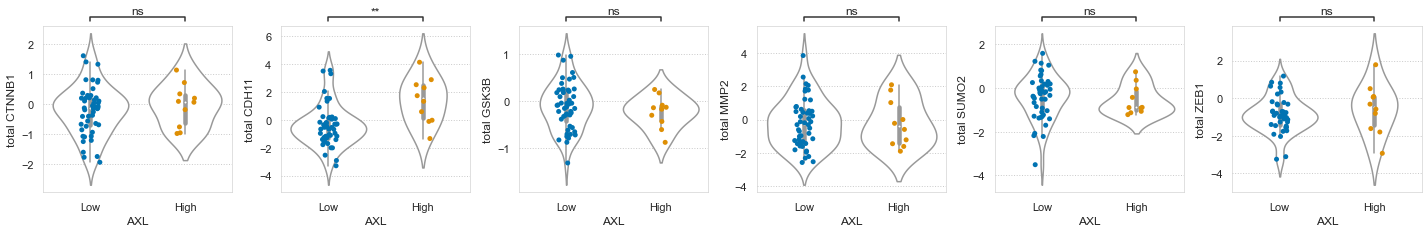

In [48]:
fig, ax = plt.subplots(1, 6, figsize=(20, 3))
fig.tight_layout()

sns.violinplot(data=protHL.loc["CTNNB1"], x="AXL", y="log(expression)", color="white", ax=ax[0])
sns.stripplot(data=protHL.loc["CTNNB1"], x="AXL", y="log(expression)", ax=ax[0]).set_ylabel("total CTNNB1")
annotate_pvals(ax[0], protHL.loc["CTNNB1"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["CDH11"], x="AXL", y="log(expression)", color="white", ax=ax[1])
sns.stripplot(data=protHL.loc["CDH11"], x="AXL", y="log(expression)", ax=ax[1]).set_ylabel("total CDH11")
annotate_pvals(ax[1], protHL.loc["CDH11"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["GSK3B"], x="AXL", y="log(expression)", color="white", ax=ax[2])
sns.stripplot(data=protHL.loc["GSK3B"], x="AXL", y="log(expression)", ax=ax[2]).set_ylabel("total GSK3B")
annotate_pvals(ax[2], protHL.loc["GSK3B"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["MMP2"], x="AXL", y="log(expression)", color="white", ax=ax[3])
sns.stripplot(data=protHL.loc["MMP2"], x="AXL", y="log(expression)", ax=ax[3]).set_ylabel("total MMP2")
annotate_pvals(ax[3], protHL.loc["MMP2"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["SUMO2"], x="AXL", y="log(expression)", color="white", ax=ax[4])
sns.stripplot(data=protHL.loc["SUMO2"], x="AXL", y="log(expression)", ax=ax[4]).set_ylabel("total SUMO2")
annotate_pvals(ax[4], protHL.loc["SUMO2"], "AXL", "log(expression)", hue=None)

sns.violinplot(data=protHL.loc["ZEB1"], x="AXL", y="log(expression)", color="white", ax=ax[5])
sns.stripplot(data=protHL.loc["ZEB1"], x="AXL", y="log(expression)", ax=ax[5]).set_ylabel("total ZEB1")
annotate_pvals(ax[5], protHL.loc["ZEB1"], "AXL", "log(expression)", hue=None)

plt.savefig("MesenchMarkers3.svg")

### Enrichment of pathways signatures in AXLhi tumors

#### RNA

In [46]:
# hi_and_low = prot_axl[(prot_axl["Levels"] == "High") | (prot_axl["Levels"] == "Low")]
# rnaAXL = rna[list(hi_and_low.index)]
# samples = list(hi_and_low["Levels"])
# assert np.all(list(rnaAXL.columns) == list(hi_and_low.index)), "Samples don't match"

In [47]:
# rna_targ = rnaAXL
# rna_targ.columns = hi_and_low["Levels"].values
# rna_targ = pd.melt(frame=rna_targ.reset_index(), id_vars="geneSymbol", value_vars=rna_targ.columns[1:], value_name="log(expression)", var_name="AXL")

In [48]:
# def plot_targeted_gsea(X, gs, ax, title=None):
#     gs = [g for g in gs if g in X["geneSymbol"].values]
#     data = X.set_index("geneSymbol").loc[gs].reset_index()
#     sns.violinplot(data=data, x="AXL", y="log(expression)", ax=ax).set_title(title)

In [49]:
# onco_gs = pd.read_csv("c6.all.v7.5.1.symbols.csv")

# _, ax = plt.subplots(1, 3, figsize=(15, 5))
# yap_up = onco_gs[onco_gs["Process"] == ("YAP1_UP")].dropna(axis=1).iloc[:, 2:].values[0]
# plot_targeted_gsea(rna_targ, yap_up, ax[0], "YAP1 UP")

# yap_sign = onco_gs[onco_gs["Process"] == ("CORDENONSI_YAP_CONSERVED_SIGNATURE")].dropna(axis=1).iloc[:, 2:].values[0]
# plot_targeted_gsea(rna_targ, yap_sign, ax[1], "YAP1 CORDENSI")

# yap_sign = onco_gs[onco_gs["Process"] == ("YAP1_DN")].dropna(axis=1).iloc[:, 2:].values[0]
# plot_targeted_gsea(rna_targ, yap_up, ax[2], "YAP1 DN")


In [50]:
# _, ax = plt.subplots(1, 1)
# src_up = onco_gs[onco_gs["Process"] == ("SRC_UP.V1_UP")].dropna(axis=1).iloc[:, 2:].values[0]
# plot_targeted_gsea(rna_targ, yap_up, ax, "SRC UP")

In [51]:
# import gseapy as gp

# gs_res = gp.gsea(data=rnaAXL, 
#                  gene_sets='KEGG_2021_Human', 
#                  cls= samples, 
#                  # set permutation_type to phenotype if samples >=15s
#                  permutation_type='phenotype',
#                  permutation_num=100, 
#                  outdir='msresist/data/RNAseq/GSEA/CPTAC_gsea/KEGG',
#                  method='signal_to_noise',
#                  processes=4, seed= 7,
#                  format='png')